In [2]:
%load_ext autoreload
%autoreload 2

import os
os.chdir("/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl")
from travel import init_travel
init_travel()

/home/sstorks/.cache/pypoetry/virtualenvs/travel-nQET-zRt-py3.10/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [82]:
import json
import os

# RESULTS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug250/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug250_llava-1.5-7b-hf_beam8-4_coherence_icl20_nohistory_20240815204213"
# RESULTS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug250/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug250_llava-1.5-7b-hf_beam8-4_likelihood_nohistory_20240815204213"
RESULTS_PATH = "/home/sstorks/coe-chaijy/sstorks/simulation_informed_pcr4nlu/TRAVEl/saved_results_222/vqa_mistake_detection/ego4d_single_debug250/llava-1.5-7b-hf/IterativeVQA_q10_ego4d_single_debug250_llava-1.5-7b-hf_beam8-4_coherence_icl20_nohistory_agla2.0_20240817190319"

with open(os.path.join(RESULTS_PATH, "outputs_val.json"), "r") as f:
    all_results_dicts = json.load(f)
    
with open(os.path.join(RESULTS_PATH, "metrics_coherence_nli_val.json"), "r") as f:
    coherence_metrics = json.load(f)

Get positive/negative form of informativeness for better visualization:

In [83]:
import numpy as np
from pprint import pprint

# TODO: once we have access to raw coherence metrics in test results, use 'informativeness_marginal_ref' in them to get positive and negative results - there may be some cases of failure of reasoning in the VLM this could expose
k = 'informativeness_marginal_by_turn'
unsure_range = 0.1

example_inf = []

for example_idx, results_dict in enumerate(list(all_results_dicts.values())):
    this_metrics = []
    for question_idx in range(results_dict['final_turn'] + 1):
        this_inf = round(float(coherence_metrics['metrics_by_turn'][k][example_idx][question_idx]), 6)
        this_metrics.append(this_inf)
            
    # In metric for full example, don't count informativeness for "unsure" answers - model failed to get new information
    this_metrics = [this_metrics[question_idx] if np.abs(results_dict['answer_probs'][question_idx][0] - 0.5) >= unsure_range or "informativeness" not in k else 0.0 for question_idx in range(len(this_metrics))]
    example_metric = round(float(np.max(this_metrics)), 6)
    if example_metric < 0:
        # If all the outputs are negative, use the most negative one instead
        example_metric = round(float(np.min(this_metrics)), 6)
    example_inf.append(example_metric)
    
pprint(example_inf[:10])

[0.410156,
 0.326172,
 0.883789,
 0.959473,
 0.971191,
 0.606445,
 0.939941,
 0.625977,
 0.952148,
 0.010742]


In [84]:
import numpy as np
from pprint import pprint
from tqdm import tqdm

from travel.model.mistake_detection import MISTAKE_DETECTION_THRESHOLDS

accuracy = []
informativeness = []
relevance = []

assert len(all_results_dicts) == len(example_inf) == len(coherence_metrics['metrics_by_example']['relevance_marginal_by_example'])
for output, ex_informativeness, ex_relevance in tqdm(zip(all_results_dicts.values(), example_inf, coherence_metrics['metrics_by_example']['relevance_marginal_by_example'])):
    target_success_prob = 0.0 if output['mistake'] else 1.0
    actual_success_prob = output['success_probs'][output['final_turn']]
    
    accuracy.append(1.0 - np.abs(target_success_prob - actual_success_prob))
    
    relevance.append(ex_relevance)
    
    informativeness.append(ex_informativeness)
    
pprint(list(zip(accuracy, relevance, informativeness))[:10])

500it [00:00, 421538.09it/s]

[(0.955651, 0.62793, 0.410156),
 (0.983214, 0.646973, 0.326172),
 (0.999975, 0.974609, 0.883789),
 (3.900000000001125e-05, 0.249023, 0.959473),
 (0.014956999999999998, 0.860718, 0.971191),
 (0.999559, 0.907715, 0.606445),
 (0.984927, 0.951172, 0.939941),
 (0.996235, 0.57666, 0.625977),
 (0.99764, 0.986816, 0.952148),
 (0.022803000000000018, 0.437012, 0.010742)]


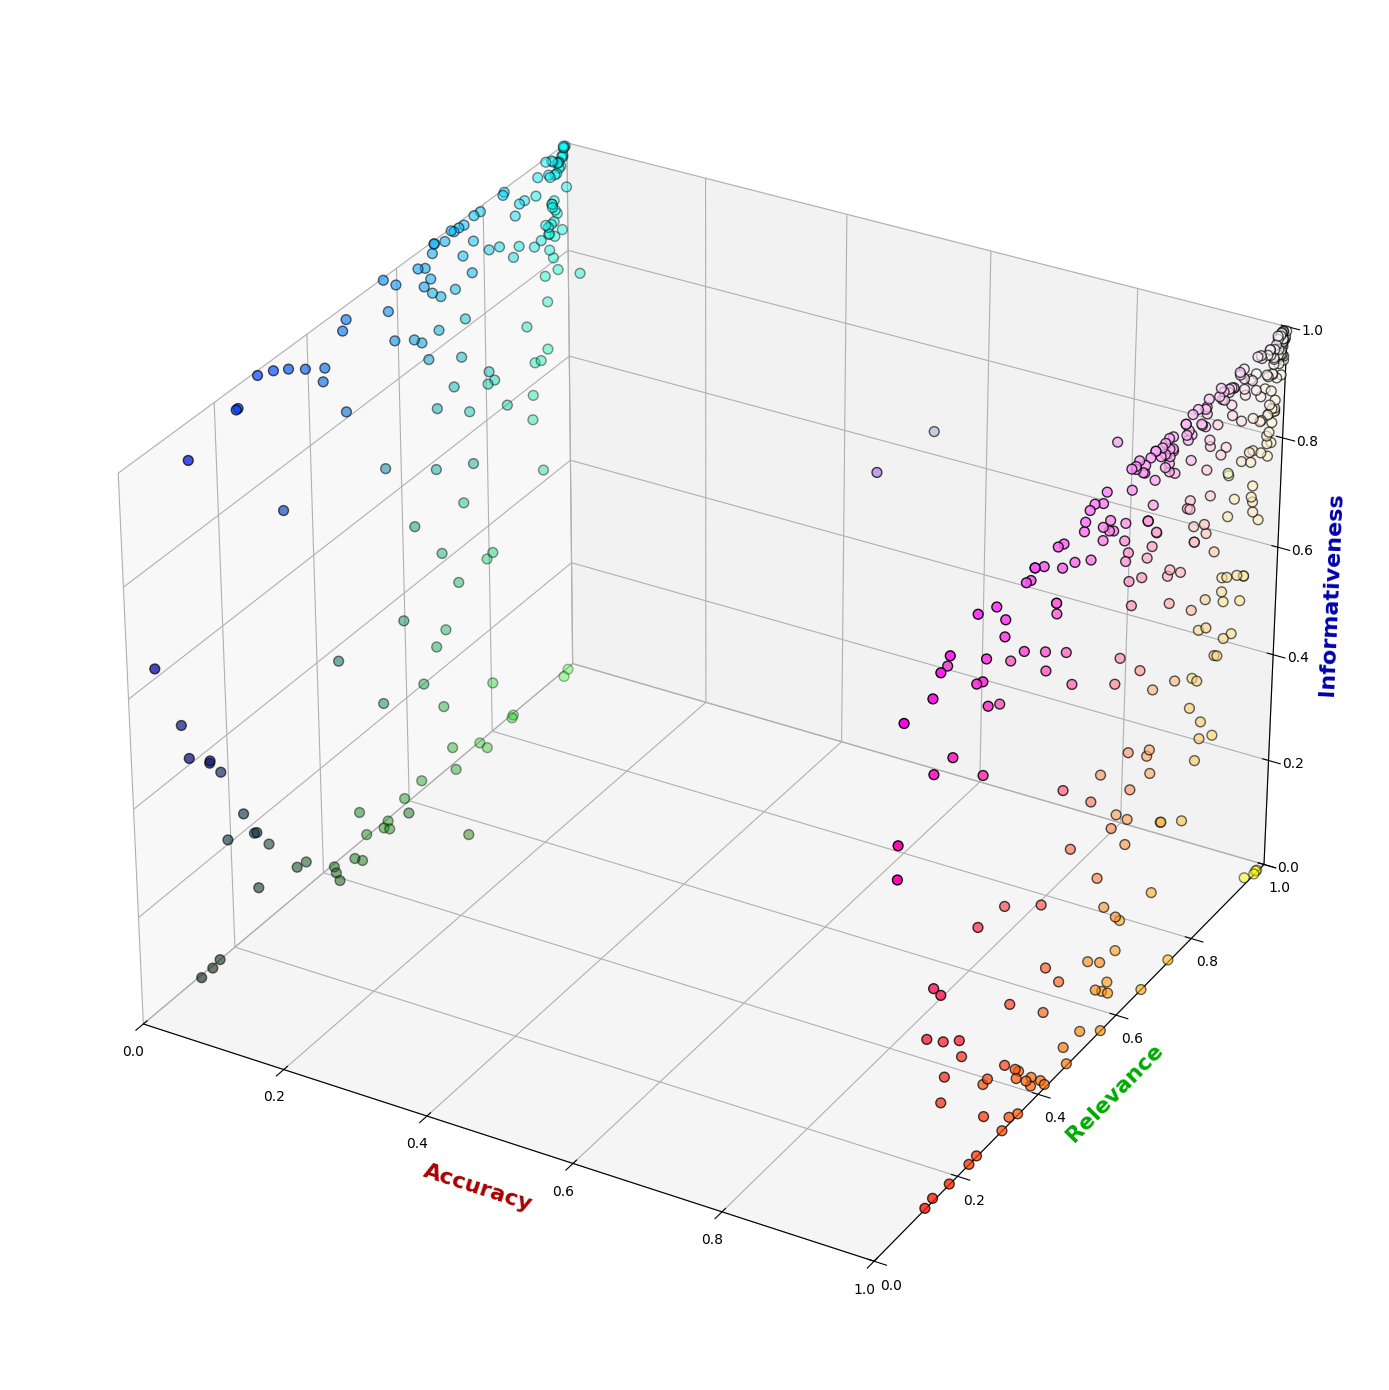

In [88]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

# Sample data
x = accuracy
y = relevance
z = informativeness

# Normalize the values for coloring
x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))
y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))
z_norm = (z - np.min(z)) / (np.max(z) - np.min(z))

# Combine the normalized values to get the colors
colors = np.array([x_norm, y_norm, z_norm]).T

fig = plt.figure(figsize=(14, 14))  # Increase the figure size
ax = fig.add_subplot(111, projection='3d')

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=colors, s=50, edgecolor='k')

# Set axis labels
ax.set_xlabel('Accuracy', labelpad=5, fontsize=16, fontweight='bold')
ax.set_ylabel('Relevance', labelpad=5, fontsize=16, fontweight='bold')
ax.set_zlabel('Informativeness', labelpad=5, fontsize=16, fontweight='bold')

ax.xaxis.label.set_color('#AA0000')
ax.yaxis.label.set_color('#00AA00')
ax.zaxis.label.set_color('#0000AA')

# Set axis limits
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_box_aspect(aspect=None, zoom=0.95)

plt.tight_layout()

# Display the plot
plt.show()

Next: grab example outputs from different regions

In [86]:
lowA_highR_highI = []

for output, acc, rel, inf in zip(all_results_dicts.values(), accuracy, relevance, informativeness):
    
    if acc < 0.1 and rel > 0.9 and inf > 0.9:
        lowA_highR_highI.append(output)

NameError: name 'highA_lowR_lowI' is not defined

In [76]:
random_outputs_to_visualize = [random.choice(lowA_highR_lowI)]


Procedure: Put the glass on the chopboard (mistake: MisalignSRL_V_ARG1)

Q1: Is the glass on the chopboard?
A1: Yes ([0.173288, 0.826712])
Success probability 1: 0.980129


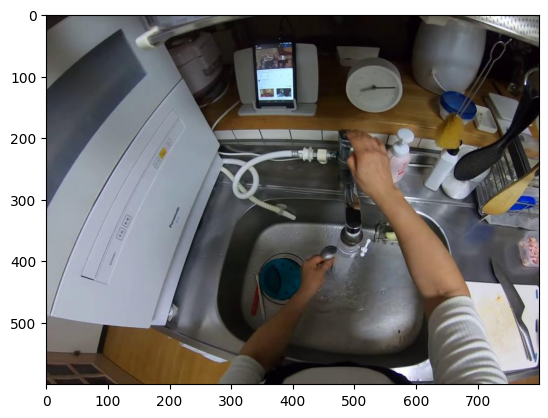

In [77]:
from PIL import Image
import random

for output in random_outputs_to_visualize:
    
    frame_dir = os.path.join(output['frame_dir'], "frames")
    possible_frame_dirs = [frame_dir.replace("_debug250", f"_partition{i+1}of4") for i in range(4)]
    frame = None
    for pfd in possible_frame_dirs:
        try:
            frame_path = os.path.join(pfd, os.listdir(pfd)[0]) # only a single frame in frame dir
            frame = Image.open(frame_path)
            break
        except Exception as e:
            continue
    if frame is not None:
        plt.figure()
        plt.imshow(frame)
    
    print(f"Procedure: {output['procedure']} ({'mistake' if output['mistake'] else 'success'}: {output['mistake_type']})")
    print("")
    for i in range(output['final_turn'] + 1):     
        
        print(f"Q{i+1}: {output['questions'][i]}")
        print(f"A{i+1}: {output['answers'][i]} ({output['answer_probs'][i]})")
        print(f"Success probability {i+1}: {output['success_probs'][i]}")